### Local Binary Patterns + XGBoost

Алгоритм Local Binary Patterns (LBP, локальний бінарний шаблон) використовується для виділення текстурних ознак на зображеннях. Він перетворює кожен піксель зображення в ціле число, яке характеризує локальну текстуру навколо цього пікселя. LBP широко застосовується у таких задачах як розпізнавання обличчя, класифікація текстур і комп'ютерний зір.
Алгоритм роботи LBP

Ось основні кроки роботи алгоритму LBP:  

1. Вводимо центральний піксель

Для початку потрібно вибрати «центральний» піксель у аналізованій області. Потім розглядаємо його сусідів у певному радіусі (наприклад, радіус = 1 означає аналіз сусідів, що утворюють квадратну область 3×3).  

2. Визначаємо радіус і кількість сусідів

У класичному LBP беруть сусіди в квадратній області, але є варіанти використання концентричних кіл або довільних форм. Кількість сусідніх пікселів (зазвичай ( P )) і радіус (( R )) задаються як параметри.  

3. Визначаємо бінарний шаблон

Для кожного сусіднього пікселя порівнюємо його значення із значенням центрального. Якщо значення сусіда більше або дорівнює центральному, присвоюємо цьому сусідньому пікселю 1, якщо менше — 0. У результаті отримуємо бінарний вектор із ( P ) бітів.  

4. Формуємо числовий код

Після отримання бінарного шаблону преобразовуємо його в десяткове число, об'єднуючи біти в одне число. Це значення і є локальним бінарним шаблоном для центрального пікселя.  

Наприклад:

    Центральний піксель має значення 100.
    Сусіди: [90, 110, 100, 120, 95, 80, 85, 105].
    Порівнюємо кожного сусіда з центральним: [0, 1, 1, 1, 0, 0, 0, 1].
    Отримуємо бінарний код: 01110001.
    Перетворюємо в десяткове число: ( 2^6 + 2^5 + 2^4 + 2^0 = 113 ).
  
5. Утворення гістограми

Після розрахунку кодів для всіх пікселів зображення (або його області), будують гістограму частоти появи унікальних кодів. Ця гістограма служить текстурною ознакою зображення.

6. Розширений варіант LBP. 

Існують модифікації LBP — наприклад, Uniform LBP (уніфікований LBP), який враховує лише певні бінарні патерни (ті, що мають не більше двох переходів між 0 і 1 у бінарному шаблоні). Це зменшує разом кількість можливих варіантів і робить ознаки більш значущими.

#### Імпортуємо необхідні бібліотеки

З головного тут XGBoost та local_binary_pattern

In [74]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import random
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import time

In [75]:
import warnings
# Вимкнути всі попередження для видаленн зайвої інформації з консолі
warnings.filterwarnings('ignore')

#### Функції виділення ознак


LBP фокусується на текстурі, тому додавання інформації про колір може значно розширити можливості класифікатора.
В даному дослідженні до LBP ознак буде додано інформацію значення пікселя в каналі RGB.


Для оцінки ефективності запропоноваго методу підготуємо 3 різні функції виділення ознак.




In [76]:
def prepare_data_with_colored_mask(image, mask, color_to_class, pixel_sample_percentage):
    """
    Вибирає координати та мітки із кольорової маски для тренування та генерує маску тренувальних пікселів.
    
    Parameters:
        image: Вхідне RGB-зображення.
        mask: Вхідна кольорова маска (BGR), яка вказує на мітки класів.
        color_to_class: Словник, що зв'язує кольори маски з індексами класів.
        pixel_sample_percentage: Відсоток пікселів для вибору в тренувальну підвибірку.
    
    Returns:
        sampled_coordinates: Список координат [(y, x)] вибраних пікселів.
        sampled_labels: Список міток класів для вибраних пікселів.
        temp_training_mask: Проміжна маска, що містить лише використовувані у тренуванні пікселі.
    """
    coordinates = []
    labels = []
    
    # Ініціалізуємо порожню маску для візуалізації тренувальних пікселів
    training_mask = np.ones_like(mask) * 255  # Маска спочатку біла (не використані пікселі)
    
    # Проходимо через пікселі вхідної маски
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            b, g, r = mask[y, x]  # OpenCV використовує формат BGR
            color = (r, g, b)
            if color in color_to_class:
                coordinates.append((y, x))
                labels.append(color_to_class[color])
                # Копіюємо кольори з оригінальної маски в проміжну маску
                training_mask[y, x] = mask[y, x]
            elif color == (255, 255, 255):  # Ігноруємо білі пікселі
                continue

    # Перемішуємо та відбираємо пікселі
    combined = list(zip(coordinates, labels))
    random.shuffle(combined)
    coordinates, labels = zip(*combined)
    
    # Вибираємо підмножину пікселів для тренування
    sample_size = int(len(coordinates) * pixel_sample_percentage)
    sampled_coordinates = coordinates[:sample_size]
    sampled_labels = labels[:sample_size]
    
    # Змінюємо training_mask так, щоб залишилася тільки підвибірка
    temp_training_mask = np.ones_like(mask) * 255  # Створюємо нову маску з білим фоном
    for (y, x) in sampled_coordinates:
        temp_training_mask[y, x] = mask[y, x]  # Копіюємо тільки координати вибірки
    
    # Повертаємо результати
    return sampled_coordinates, sampled_labels, temp_training_mask

In [77]:
def extract_pixel_features_rgb(image, coordinates):
    """
    Extract RGB values for each pixel coordinate (without LBP).
    
    Parameters:
        image: RGB input image.
        coordinates: List of pixel coordinates [(y1, x1), (y2, x2), ...].
    
    Returns:
        np.array: Feature vectors containing only RGB values for each pixel.
    """
    features = []
    
    # Loop through each coordinate and extract RGB values
    for coord in coordinates:
        y, x = coord
        # Extract RGB values at the given coordinate
        rgb_values = [image[y, x, 2], image[y, x, 1], image[y, x, 0]]  # RGB (order: R, G, B)
        
        # Append RGB values to features list
        features.append(rgb_values)
    
    # Return features array
    return np.array(features)

In [78]:
def extract_pixel_features_rgb_with_lbp(image, coordinates, radius=1, n_points=8, method='uniform'):
    """
    Extract LBP features for each pixel coordinate.

    Parameters:
        image: RGB input image.
        coordinates: List of pixel coordinates [(y1, x1), (y2, x2), ...].
        radius: Radius for the LBP descriptor.
        n_points: Number of sampling points for the LBP descriptor.
        method: LBP calculation method ('uniform', 'default', etc.).

    Returns:
        np.array: Feature vectors for each pixel based only on LBP features.
    """
    features = []
    b_channel, g_channel, r_channel = cv2.split(image)  # Split RGB image into its channels

    for coord in coordinates:
        y, x = coord
        lbp_features = []
        # Extract LBP features for each channel
        for channel in [b_channel, g_channel, r_channel]:
            # Define the local patch around the pixel
            patch = channel[max(0, y - radius):min(channel.shape[0], y + radius + 1),
                            max(0, x - radius):min(channel.shape[1], x + radius + 1)]
            # Resize patch if it's smaller than expected
            if patch.shape[0] < 2 * radius + 1 or patch.shape[1] < 2 * radius + 1:
                patch = cv2.resize(patch, (2 * radius + 1, 2 * radius + 1))
            
            # Compute LBP for the patch
            lbp = local_binary_pattern(patch, P=n_points, R=radius, method=method)
            lbp_features.extend(lbp.flatten())  # Flatten LBP features and add them for this channel
        
        # Append only LBP features (no RGB values) to the feature list
        features.append(lbp_features)

    return np.array(features)

In [79]:
def extract_pixel_features_rgb_with_lbp_and_colors(image, coordinates, radius=1, n_points=8, method='uniform'):
    """
    Extract LBP features and RGB values for each pixel coordinate.
    
    Parameters:
        image: RGB input image.
        coordinates: List of pixel coordinates [(y1, x1), (y2, x2), ...].
        radius: Radius for the LBP descriptor.
        n_points: Number of sampling points for the LBP descriptor.
        method: LBP calculation method ('uniform', 'default', etc.).
    
    Returns:
        np.array: Feature vectors for each pixel.
    """
    features = []
    b_channel, g_channel, r_channel = cv2.split(image)

    for coord in coordinates:
        y, x = coord
        lbp_features = []
        for channel in [b_channel, g_channel, r_channel]:
            patch = channel[max(0, y - radius):min(channel.shape[0], y + radius + 1),
                            max(0, x - radius):min(channel.shape[1], x + radius + 1)]
            if patch.shape[0] < 2 * radius + 1 or patch.shape[1] < 2 * radius + 1:
                patch = cv2.resize(patch, (2 * radius + 1, 2 * radius + 1))
            lbp = local_binary_pattern(patch, P=n_points, R=radius, method=method)
            lbp_features.extend(lbp.flatten())

        rgb_values = [r_channel[y, x], g_channel[y, x], b_channel[y, x]]
        feature_vector = np.concatenate((lbp_features, rgb_values))
        features.append(feature_vector)

    return np.array(features)

### Навчання моделі

Використаємо стандартний підхід до навчання, коли навчальні дані розбиваються на дві частини: тенувальні дані та перевірочні дані.

In [80]:
def train_xgboost_classifier(features, labels):
    """
    Train an XGBoost classifier.
    
    Parameters:
        features: Feature matrix (N x M, where M is the feature size).
        labels: Corresponding labels (N x 1).
    
    Returns:
        Trained XGBoost model.
    """
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        n_estimators=300,
        max_depth=6,
        eta=0.3
    )
    model.fit(X_train, y_train)
    
    # Evaluate model performance
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return model

### Функція класифікація

В даній функції передбачена можливість використання різних векторів: лише Color, лише LBP та LBP + Color.

Це зроблено для оцінки ефективності запропонованого рішення.

In [81]:
def classify_entire_image(image, model, radius=1, n_points=8, class_to_color=None, expected_size=None, use_color=True, use_lbp=True):
    """
    Classify each pixel in the input image using the trained model with support for LBP, RGB, or LBP+RGB features.

    Parameters:
        image: Input RGB image.
        model: Trained XGBoost model or any compatible classifier.
        radius: Radius for the LBP descriptor.
        n_points: Number of sampling points for the LBP descriptor.
        class_to_color: Mapping of class indices to RGB colors.
        expected_size: Expected size of feature vectors for inference (must match training).
        use_color: Whether to include RGB color values in the feature vector (True to include RGB).
        use_lbp: Whether to include LBP features in the feature vector (True to include LBP).

    Returns:
        full_mask: Output classification mask (RGB image).
    """
    height, width = image.shape[:2]
    full_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Loop through each pixel and classify
    for y in range(height):
        for x in range(width):
            feature_vector = []  # This will store both LBP and/or RGB features based on settings

            # Extract LBP features if enabled
            if use_lbp:
                lbp_features = []
                for channel in cv2.split(image):
                    # Extract local patch around the pixel
                    patch = channel[max(0, y - radius):min(channel.shape[0], y + radius + 1),
                                    max(0, x - radius):min(channel.shape[1], x + radius + 1)]
                    if patch.shape[0] < 2 * radius + 1 or patch.shape[1] < 2 * radius + 1:
                        patch = cv2.resize(patch, (2 * radius + 1, 2 * radius + 1))
                    # Compute LBP for the local patch
                    lbp = local_binary_pattern(patch, P=n_points, R=radius, method='uniform')
                    lbp_features.extend(lbp.flatten())  # Append LBP features for the channel
                feature_vector.extend(lbp_features)  # Add LBP features to the feature vector

            # Extract color features if enabled
            if use_color:
                rgb_values = [image[y, x, 2], image[y, x, 1], image[y, x, 0]]  # RGB order
                feature_vector.extend(rgb_values)  # Add RGB values to the feature vector

            # Convert feature vector to np.array
            feature_vector = np.array(feature_vector)

            # Ensure feature vector size matches the expected size for the model
            if expected_size is None:
                # Retrieve the expected size from the model
                expected_size = len(model.feature_names_in_)
            if feature_vector.shape[0] != expected_size:
                if feature_vector.shape[0] < expected_size:
                    feature_vector = np.pad(feature_vector, (0, expected_size - feature_vector.shape[0]), mode='constant')
                elif feature_vector.shape[0] > expected_size:
                    feature_vector = feature_vector[:expected_size]  # Truncate features if too large

            # Run prediction for the pixel
            prediction = model.predict(np.array([feature_vector]))[0]
            # Map the prediction to the corresponding color
            full_mask[y, x] = class_to_color[prediction]

    return full_mask

### Окрема функція для перевірки моделі

Дана функція оцінює точність класифікація відповідно до наданої маски. Це надає можливість провести чистий експеремент коли дані яку були використані для тренування та перевірки моделі, та дані які будуть використовуватись для оцінки моделі повністю відрізняються та не пересікаються.

In [82]:

def evaluate_classification_results(resulting_mask, eval_mask, color_to_class):
    """
    Оцінює точність класифікації на основі повної маски для оцінки.

    Parameters:
        resulting_mask: Класифікована маска (BGR).
        eval_mask: Маска для оцінки точності (BGR).
        color_to_class: Словник, що встановлює відповідність кольорів класам.

    Returns:
        accuracy: Точність класифікації.
        report: Повний звіт класифікації.
    """
    eval_labels = []
    predicted_labels = []
    
    # Білий колір (зазвичай ігноровані пікселі)
    ignored_color = (255, 255, 255)  # Білий у форматі BGR

    # Проходимо через пікселі оцінкової маски
    for y in range(eval_mask.shape[0]):
        for x in range(eval_mask.shape[1]):
            eval_color = tuple(eval_mask[y, x])  # BGR формат
            predicted_color = tuple(resulting_mask[y, x])  # BGR формат

            # Ігнорувати пікселі білого кольору
            if eval_color == ignored_color:
                continue

            # Перевіряємо, чи кольори присутні в словнику для оцінки
            if eval_color in color_to_class:
                eval_labels.append(color_to_class[eval_color])
            else:
                print(f"Warning: eval_color {eval_color} не знайдено в color_to_class.")
                continue  # Пропускаємо, якщо eval_color немає в словнику
                
            if predicted_color in color_to_class:
                predicted_labels.append(color_to_class[predicted_color])
            else:
                print(f"Warning: predicted_color {predicted_color} не знайдено в color_to_class.")
                continue  # Пропускаємо, якщо predicted_color немає в словнику

    # Якщо після всіх перевірок немає пікселів для обчислення, повернемо нульові значення
    if len(eval_labels) == 0 or len(predicted_labels) == 0:
        print("Warning: У обраній області немає відповідних пікселів для оцінки.")
        return 0.0, "No data available for evaluation."

    # Використовуємо sklearn для оцінки точності
    accuracy = accuracy_score(eval_labels, predicted_labels)
    report = classification_report(eval_labels, predicted_labels, zero_division=0)
    
    return accuracy, report

### Головна функція

В даній функції описуються кроки які необхідно виконати для підгтовки даних, навчання моделі та оцінки якості.
Тут ми задаємо тренувальні дані, дані які необхідно класифікувати та використовуємо різноманітні перевірки.

Ми підготуємо 3 окремі функції для перевірки наступних моделей:
1. Color + XGBoost
2. LBP + XGBoost
3. (LBP + Color) + XGBoost

Оцінимо роботу на основі двох зображень Sentinel data (SS1 та SS2).

### Color + XGBoost

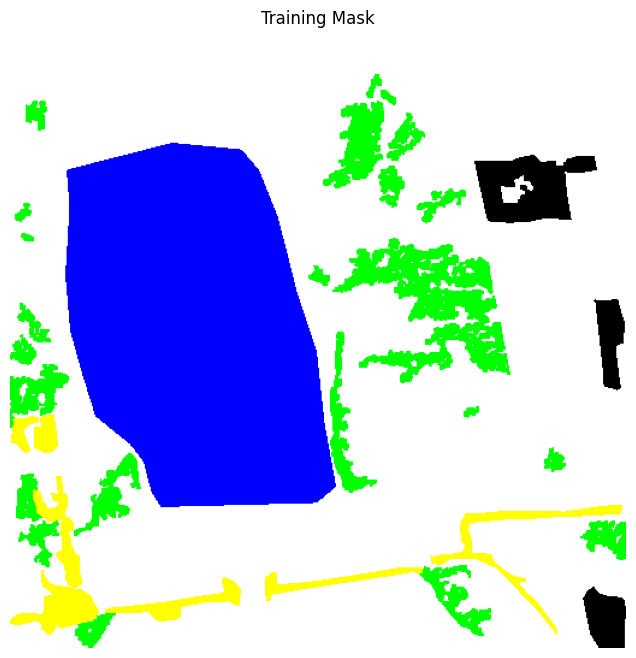

Accuracy: 96.80%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15691
           1       0.95      0.97      0.96      6009
           2       0.84      0.87      0.85      1862
           3       0.90      0.83      0.87      2233

    accuracy                           0.97     25795
   macro avg       0.92      0.92      0.92     25795
weighted avg       0.97      0.97      0.97     25795



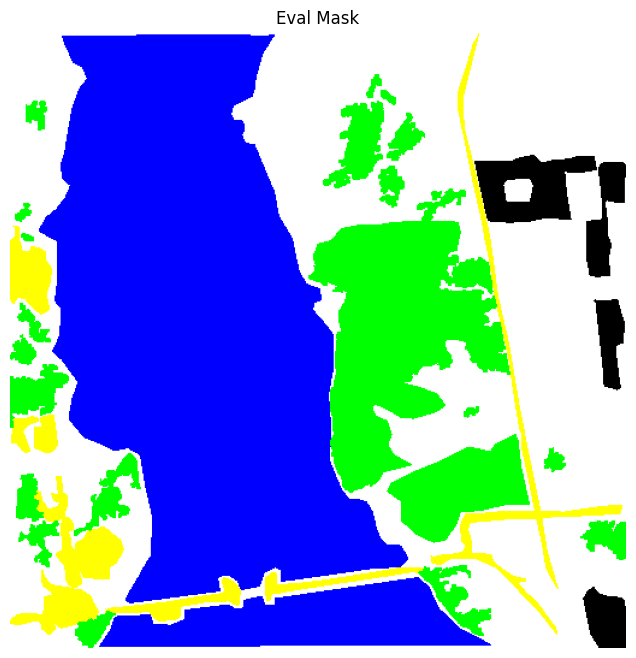

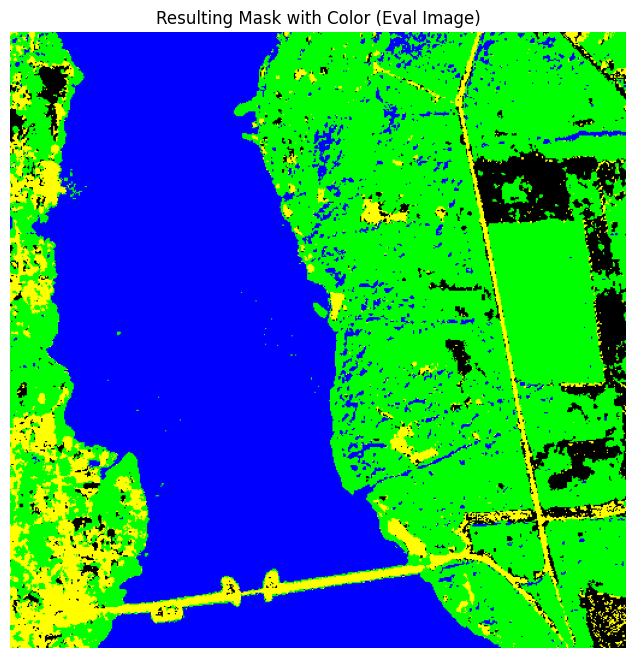

Unique colors in eval_mask (BGR): {(0, 0, 0): 7898, (0, 255, 0): 38258, (0, 255, 255): 12154, (255, 0, 0): 96852, (255, 255, 255): 106982}
Evaluation Accuracy on Eval Image: 95.52%
Evaluation Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     96852
           1       0.94      0.93      0.93     38258
           2       0.78      0.85      0.81      7898
           3       0.91      0.78      0.84     12154

    accuracy                           0.96    155162
   macro avg       0.90      0.89      0.89    155162
weighted avg       0.96      0.96      0.95    155162

Time taken for first image pair processing: 66.66 seconds


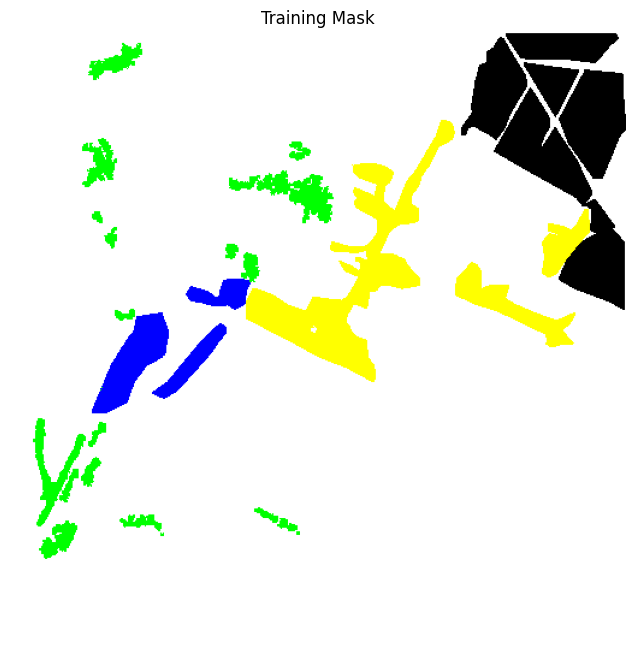

Accuracy: 91.24%
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1218
           1       0.82      0.86      0.84      1778
           2       0.94      0.95      0.95      4518
           3       0.93      0.88      0.91      3510

    accuracy                           0.91     11024
   macro avg       0.90      0.90      0.90     11024
weighted avg       0.91      0.91      0.91     11024



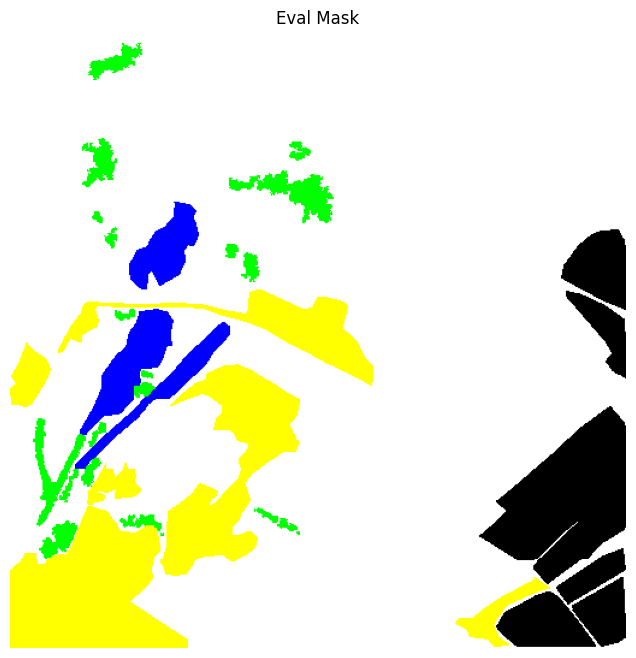

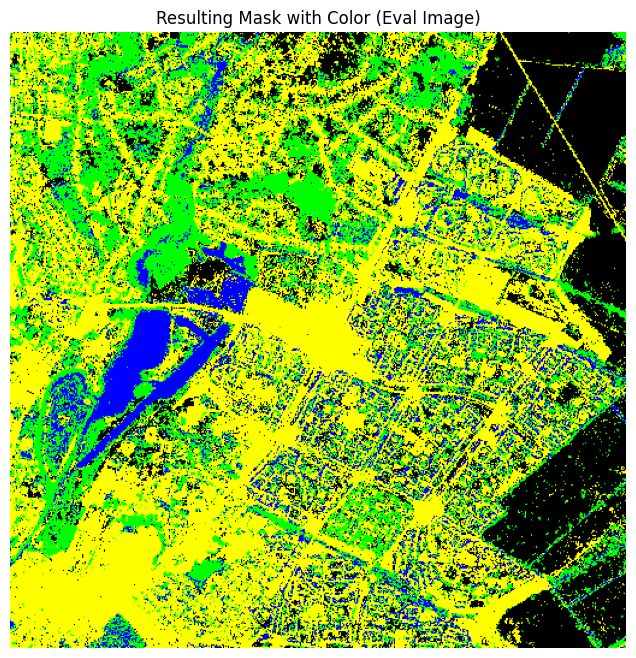

Unique colors in eval_mask (BGR): {(0, 0, 0): 19125, (0, 255, 0): 6032, (0, 255, 255): 28040, (255, 0, 0): 7117, (255, 255, 255): 201830}
Evaluation Accuracy on Eval Image: 85.67%
Evaluation Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      7117
           1       0.50      0.90      0.65      6032
           2       0.93      0.87      0.90     19125
           3       0.95      0.89      0.92     28040

    accuracy                           0.86     60314
   macro avg       0.81      0.83      0.80     60314
weighted avg       0.89      0.86      0.86     60314

Time taken for second image pair processing: 65.18 seconds
Total time taken: 131.84 seconds


In [87]:
if __name__ == "__main__":
    # Підрахунок часу для всього процесу
    total_start_time = time.perf_counter()

    # --- Обробка першого набору зображень ---
    process_start_time = time.perf_counter()
    
    # Шляхи до зображень   
    image_path = "Images/sentinel/SS1/SS1.bmp"
    eval_image_path = "Images/sentinel/SS1/SS1.bmp"  # Шумлене зображення
    
    # Шляхи до масок
    train_mask_path = "Images/sentinel/SS1/Samples1.bmp"  # Маска для тренування
    eval_mask_path = "Images/sentinel/SS1/Etalon1.bmp"  # Маска для оцінки точності класифікації (повна)
    
    # Завантажуємо зображення та маски
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    eval_image = cv2.imread(eval_image_path, cv2.IMREAD_COLOR)  # Зашумлене зображення
    train_mask = cv2.imread(train_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask = cv2.imread(eval_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask_rgb = cv2.cvtColor(eval_mask, cv2.COLOR_BGR2RGB) # Маска для оцінки точності

    # Встановлюємо колір-клас відповідність:
    color_to_class = {
        (0, 0, 255): 0,    # Синій - Вода
        (0, 255, 0): 1,    # Зелений - Рослинність
        (0, 0, 0): 2,      # Чорний - Відкритий ґрунт
        
        (255, 255, 0): 3   # Жовтий - Урбанізація
    }

    class_to_color = {v: k for k, v in color_to_class.items()}  # Зворотня відповідність для класифікованого результату

    # === Тренування моделі ===
    sampled_coordinates, sampled_labels, training_mask = prepare_data_with_colored_mask(
        rgb_image, train_mask, color_to_class, pixel_sample_percentage=1.0
    )

    # Візуалізуємо вибрану тренувальну маску
    training_mask_rgb = cv2.cvtColor(training_mask, cv2.COLOR_BGR2RGB)  # Переводимо в RGB для matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(training_mask_rgb)
    plt.axis('off')
    plt.title("Training Mask")
    plt.show()
    cv2.imwrite("Images/temp/training_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу

    # Only RGB
    features = extract_pixel_features_rgb(
        rgb_image, sampled_coordinates
    )

    # # Only LBP
    # features = extract_pixel_features_rgb_with_lbp(
    #     rgb_image, sampled_coordinates, radius=2, n_points=16
    # )

    # # LBP + RGB
    # features = extract_pixel_features_rgb_with_lbp_and_colors(
    #     rgb_image, sampled_coordinates, radius=2, n_points=16
    # )

    # Тренуємо модель XGBoost
    model = train_xgboost_classifier(features, sampled_labels)
    
    # # === Класифікація чистого зображення ===
    # resulting_mask = classify_entire_image(
    #     rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=True, use_lbp=False
    # )
    # resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB для matplotlib
    # plt.figure(figsize=(8, 8))
    # plt.imshow(resulting_mask)
    # plt.axis('off')
    # plt.title("Resulting Mask with Color (Clean Image)")
    # plt.show()
    # cv2.imwrite("Images/temp/result_colored_mask_lbp_clean.png", resulting_mask_rgb)  # Зберігаємо результат
    
    # === Класифікація первірочного зображення ===   

    # Візуалізуємо вибрану перевірочну маску
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_mask_rgb)
    plt.axis('off')
    plt.title("Eval Mask")
    plt.show()
    cv2.imwrite("Images/temp/eval_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу
    
    eval_resulting_mask = classify_entire_image(
        eval_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=True, use_lbp=False
    )
    eval_resulting_mask_rgb = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_resulting_mask)
    plt.axis('off')
    plt.title("Resulting Mask with Color (Eval Image)")
    plt.show()
    cv2.imwrite("Images/temp/eval_result_colored_mask_lbp.png", eval_resulting_mask_rgb)  # Зберігаємо результат
    
    # === Оцінка точності на основі повної маски ===
    eval_resulting_mask_bgr = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_RGB2BGR)

    # Виведення унікальних кольорів у масці
    unique_colors_eval, counts_eval = np.unique(eval_mask.reshape(-1, 3), axis=0, return_counts=True)
    print("Unique colors in eval_mask (BGR):", dict(zip(map(tuple, unique_colors_eval), counts_eval)))
    
    eval_accuracy, eval_report = evaluate_classification_results(
        eval_resulting_mask, eval_mask_rgb, color_to_class
    )
    
    # Виведення результатів
    print(f"Evaluation Accuracy on Eval Image: {eval_accuracy * 100:.2f}%")
    print("Evaluation Classification Report:")
    print(eval_report)

    # Показуємо час для першого зображення
    process_end_time = time.perf_counter()
    print(f"Time taken for first image pair processing: {process_end_time - process_start_time:.2f} seconds")







    
    # --- Обробка другого набору зображень ---
    process_start_time = time.perf_counter()
    
    # Шляхи до зображень   
    image_path = "Images/sentinel/SS2/SS2.bmp"
    eval_image_path = "Images/sentinel/SS2/SS2.bmp"  # Шумлене зображення
    
    # Шляхи до масок
    train_mask_path = "Images/sentinel/SS2/Samples2.bmp"  # Маска для тренування
    eval_mask_path = "Images/sentinel/SS2/Etalon2.bmp"  # Маска для оцінки точності класифікації (повна)
    
    # Завантажуємо зображення та маски
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    eval_image = cv2.imread(eval_image_path, cv2.IMREAD_COLOR)  # Зашумлене зображення
    train_mask = cv2.imread(train_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask = cv2.imread(eval_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask_rgb = cv2.cvtColor(eval_mask, cv2.COLOR_BGR2RGB) # Маска для оцінки точності

    # Встановлюємо колір-клас відповідність:
    color_to_class = {
        (0, 0, 255): 0,    # Синій - Вода
        (0, 255, 0): 1,    # Зелений - Рослинність
        (0, 0, 0): 2,      # Чорний - Відкритий ґрунт
        
        (255, 255, 0): 3   # Жовтий - Урбанізація
    }

    class_to_color = {v: k for k, v in color_to_class.items()}  # Зворотня відповідність для класифікованого результату

    # === Тренування моделі ===
    sampled_coordinates, sampled_labels, training_mask = prepare_data_with_colored_mask(
        rgb_image, train_mask, color_to_class, pixel_sample_percentage=1.0
    )

    # Візуалізуємо вибрану тренувальну маску
    training_mask_rgb = cv2.cvtColor(training_mask, cv2.COLOR_BGR2RGB)  # Переводимо в RGB для matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(training_mask_rgb)
    plt.axis('off')
    plt.title("Training Mask")
    plt.show()
    cv2.imwrite("Images/temp/training_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу

    # Only RGB
    features = extract_pixel_features_rgb(
        rgb_image, sampled_coordinates
    )

    # # Only LBP
    # features = extract_pixel_features_rgb_with_lbp(
    #     rgb_image, sampled_coordinates, radius=2, n_points=16
    # )

    # # LBP + RGB
    # features = extract_pixel_features_rgb_with_lbp_and_colors(
    #     rgb_image, sampled_coordinates, radius=2, n_points=16
    # )

    # Тренуємо модель XGBoost
    model = train_xgboost_classifier(features, sampled_labels)
    
    # # === Класифікація чистого зображення ===
    # resulting_mask = classify_entire_image(
    #     rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=True, use_lbp=False
    # )
    # resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB для matplotlib
    # plt.figure(figsize=(8, 8))
    # plt.imshow(resulting_mask)
    # plt.axis('off')
    # plt.title("Resulting Mask with Color (Clean Image)")
    # plt.show()
    # cv2.imwrite("Images/temp/result_colored_mask_lbp_clean.png", resulting_mask_rgb)  # Зберігаємо результат
    
    # === Класифікація первірочного зображення ===   

    # Візуалізуємо вибрану перевірочну маску
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_mask_rgb)
    plt.axis('off')
    plt.title("Eval Mask")
    plt.show()
    cv2.imwrite("Images/temp/eval_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу
    
    eval_resulting_mask = classify_entire_image(
        eval_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=True, use_lbp=False
    )
    eval_resulting_mask_rgb = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_resulting_mask)
    plt.axis('off')
    plt.title("Resulting Mask with Color (Eval Image)")
    plt.show()
    cv2.imwrite("Images/temp/eval_result_colored_mask_lbp.png", eval_resulting_mask_rgb)  # Зберігаємо результат
    
    # === Оцінка точності на основі повної маски ===
    eval_resulting_mask_bgr = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_RGB2BGR)

    # Виведення унікальних кольорів у масці
    unique_colors_eval, counts_eval = np.unique(eval_mask.reshape(-1, 3), axis=0, return_counts=True)
    print("Unique colors in eval_mask (BGR):", dict(zip(map(tuple, unique_colors_eval), counts_eval)))
    
    eval_accuracy, eval_report = evaluate_classification_results(
        eval_resulting_mask, eval_mask_rgb, color_to_class
    )
    
    # Виведення результатів
    print(f"Evaluation Accuracy on Eval Image: {eval_accuracy * 100:.2f}%")
    print("Evaluation Classification Report:")
    print(eval_report)

    # Показуємо час для другого зображення
    process_end_time = time.perf_counter()
    print(f"Time taken for second image pair processing: {process_end_time - process_start_time:.2f} seconds")

    # Підрахунок загального часу роботи програми
    total_end_time = time.perf_counter()
    print(f"Total time taken: {total_end_time - total_start_time:.2f} seconds")

### LBP + XGBoost

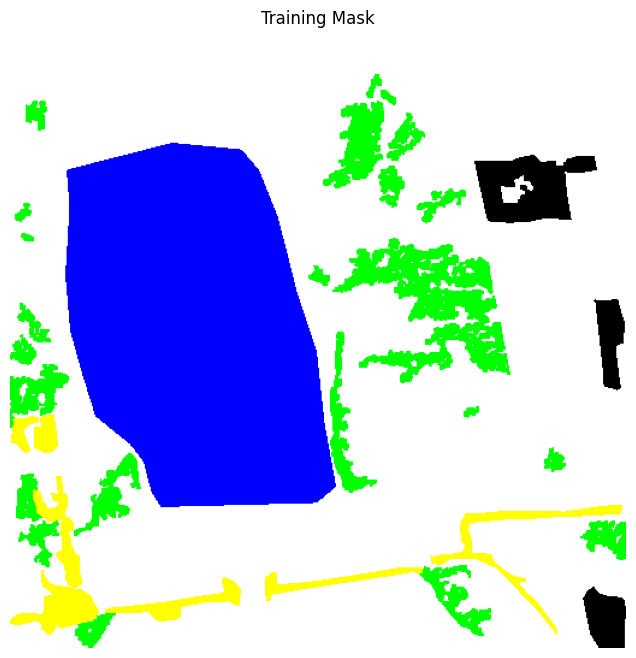

Accuracy: 90.32%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15806
           1       0.77      0.91      0.84      5898
           2       0.63      0.44      0.52      1889
           3       0.78      0.61      0.68      2202

    accuracy                           0.90     25795
   macro avg       0.79      0.74      0.76     25795
weighted avg       0.90      0.90      0.90     25795



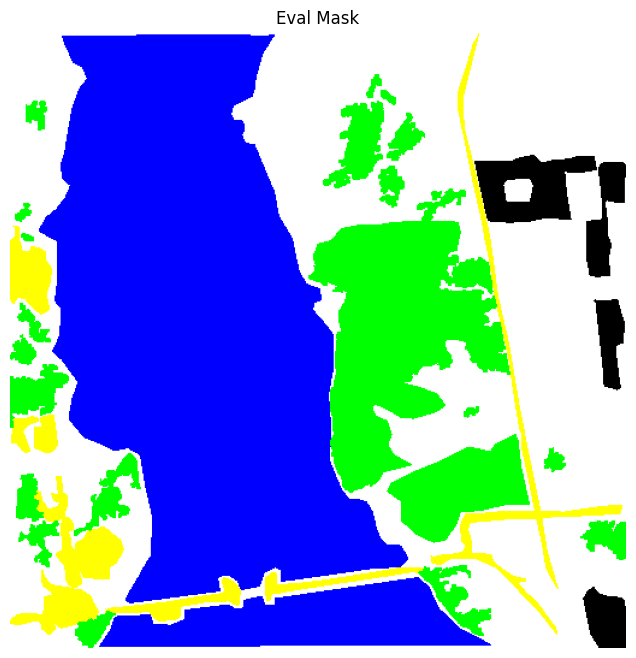

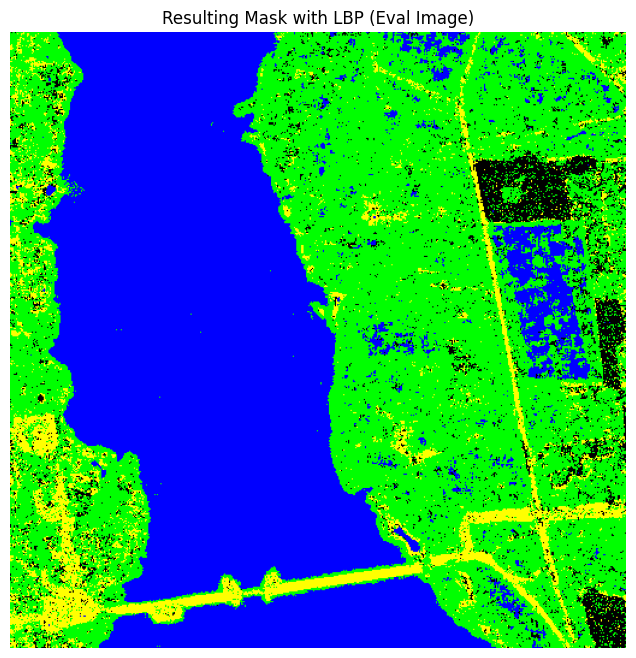

Unique colors in eval_mask (BGR): {(0, 0, 0): 7898, (0, 255, 0): 38258, (0, 255, 255): 12154, (255, 0, 0): 96852, (255, 255, 255): 106982}
Evaluation Accuracy on Eval Image: 94.15%
Evaluation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     96852
           1       0.87      0.93      0.90     38258
           2       0.77      0.71      0.74      7898
           3       0.90      0.70      0.79     12154

    accuracy                           0.94    155162
   macro avg       0.88      0.84      0.85    155162
weighted avg       0.94      0.94      0.94    155162

Time taken for first image pair processing: 148.82 seconds


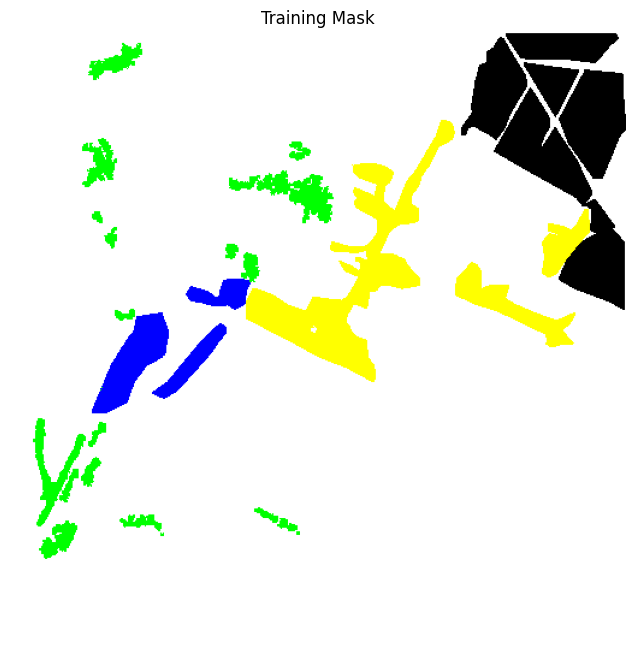

Accuracy: 73.11%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      1292
           1       0.61      0.32      0.42      1799
           2       0.71      0.85      0.77      4520
           3       0.76      0.83      0.79      3413

    accuracy                           0.73     11024
   macro avg       0.74      0.66      0.68     11024
weighted avg       0.73      0.73      0.72     11024



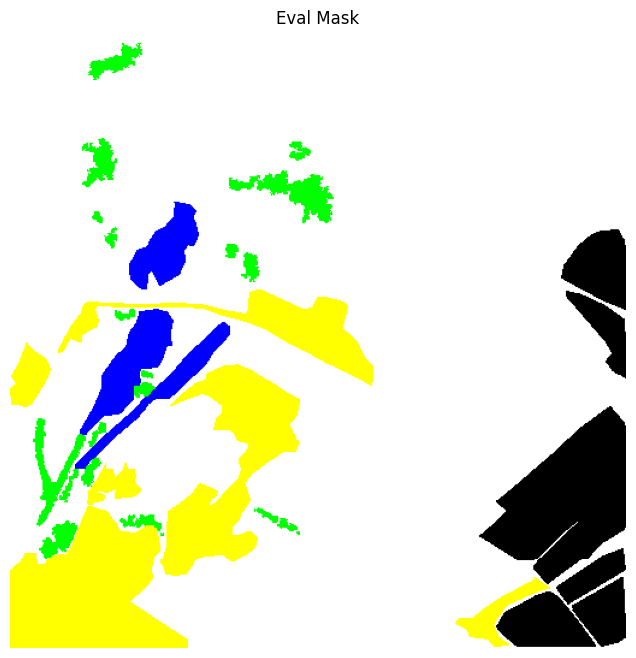

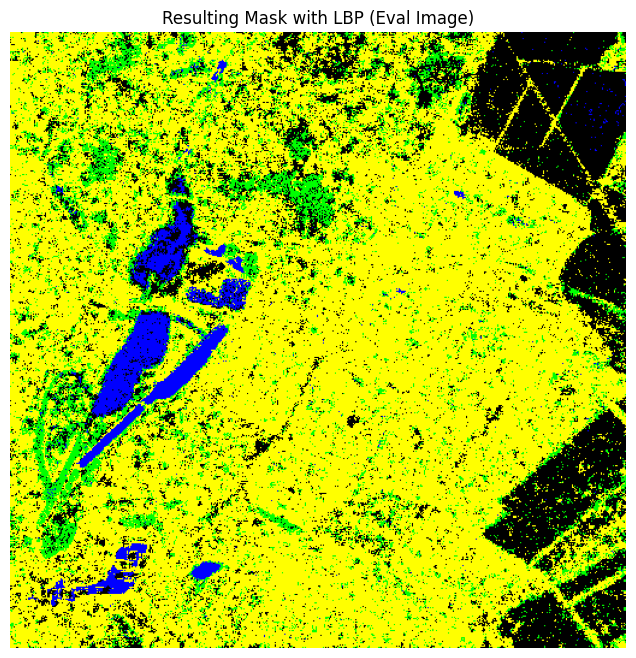

Unique colors in eval_mask (BGR): {(0, 0, 0): 19125, (0, 255, 0): 6032, (0, 255, 255): 28040, (255, 0, 0): 7117, (255, 255, 255): 201830}
Evaluation Accuracy on Eval Image: 77.52%
Evaluation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      7117
           1       0.57      0.77      0.66      6032
           2       0.72      0.76      0.74     19125
           3       0.86      0.80      0.83     28040

    accuracy                           0.78     60314
   macro avg       0.75      0.76      0.75     60314
weighted avg       0.79      0.78      0.78     60314

Time taken for second image pair processing: 197.26 seconds
Total time taken: 346.09 seconds


In [89]:
if __name__ == "__main__":
    # Підрахунок часу для всього процесу
    total_start_time = time.perf_counter()

    # --- Обробка першого набору зображень ---
    process_start_time = time.perf_counter()
    
    # Шляхи до зображень   
    image_path = "Images/sentinel/SS1/SS1.bmp"
    eval_image_path = "Images/sentinel/SS1/SS1.bmp"  # Шумлене зображення
    
    # Шляхи до масок
    train_mask_path = "Images/sentinel/SS1/Samples1.bmp"  # Маска для тренування
    eval_mask_path = "Images/sentinel/SS1/Etalon1.bmp"  # Маска для оцінки точності класифікації (повна)
    
    # Завантажуємо зображення та маски
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    eval_image = cv2.imread(eval_image_path, cv2.IMREAD_COLOR)  # Зашумлене зображення
    train_mask = cv2.imread(train_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask = cv2.imread(eval_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask_rgb = cv2.cvtColor(eval_mask, cv2.COLOR_BGR2RGB) # Маска для оцінки точності

    # Встановлюємо колір-клас відповідність:
    color_to_class = {
        (0, 0, 255): 0,    # Синій - Вода
        (0, 255, 0): 1,    # Зелений - Рослинність
        (0, 0, 0): 2,      # Чорний - Відкритий ґрунт
        
        (255, 255, 0): 3   # Жовтий - Урбанізація
    }

    class_to_color = {v: k for k, v in color_to_class.items()}  # Зворотня відповідність для класифікованого результату

    # === Тренування моделі ===
    sampled_coordinates, sampled_labels, training_mask = prepare_data_with_colored_mask(
        rgb_image, train_mask, color_to_class, pixel_sample_percentage=1.0
    )

    # Візуалізуємо вибрану тренувальну маску
    training_mask_rgb = cv2.cvtColor(training_mask, cv2.COLOR_BGR2RGB)  # Переводимо в RGB для matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(training_mask_rgb)
    plt.axis('off')
    plt.title("Training Mask")
    plt.show()
    cv2.imwrite("Images/temp/training_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу

    # # Only RGB
    # features = extract_pixel_features_rgb(
    #     rgb_image, sampled_coordinates
    # )

    # Only LBP
    features = extract_pixel_features_rgb_with_lbp(
        rgb_image, sampled_coordinates, radius=2, n_points=16
    )

    # # LBP + RGB
    # features = extract_pixel_features_rgb_with_lbp_and_colors(
    #     rgb_image, sampled_coordinates, radius=2, n_points=16
    # )

    # Тренуємо модель XGBoost
    model = train_xgboost_classifier(features, sampled_labels)
    
    # # === Класифікація чистого зображення ===
    # resulting_mask = classify_entire_image(
    #     rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=False, use_lbp=True
    # )
    # resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB для matplotlib
    # plt.figure(figsize=(8, 8))
    # plt.imshow(resulting_mask)
    # plt.axis('off')
    # plt.title("Resulting Mask with Color (Clean Image)")
    # plt.show()
    # cv2.imwrite("Images/temp/result_colored_mask_lbp_clean.png", resulting_mask_rgb)  # Зберігаємо результат
    
    # === Класифікація первірочного зображення ===   

    # Візуалізуємо вибрану перевірочну маску
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_mask_rgb)
    plt.axis('off')
    plt.title("Eval Mask")
    plt.show()
    cv2.imwrite("Images/temp/eval_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу
    
    eval_resulting_mask = classify_entire_image(
        eval_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=False, use_lbp=True
    )
    eval_resulting_mask_rgb = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_resulting_mask)
    plt.axis('off')
    plt.title("Resulting Mask with LBP (Eval Image)")
    plt.show()
    cv2.imwrite("Images/temp/eval_result_colored_mask_lbp.png", eval_resulting_mask_rgb)  # Зберігаємо результат
    
    # === Оцінка точності на основі повної маски ===
    eval_resulting_mask_bgr = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_RGB2BGR)

    # Виведення унікальних кольорів у масці
    unique_colors_eval, counts_eval = np.unique(eval_mask.reshape(-1, 3), axis=0, return_counts=True)
    print("Unique colors in eval_mask (BGR):", dict(zip(map(tuple, unique_colors_eval), counts_eval)))
    
    eval_accuracy, eval_report = evaluate_classification_results(
        eval_resulting_mask, eval_mask_rgb, color_to_class
    )
    
    # Виведення результатів
    print(f"Evaluation Accuracy on Eval Image: {eval_accuracy * 100:.2f}%")
    print("Evaluation Classification Report:")
    print(eval_report)

    # Показуємо час для першого зображення
    process_end_time = time.perf_counter()
    print(f"Time taken for first image pair processing: {process_end_time - process_start_time:.2f} seconds")







    
    # --- Обробка другого набору зображень ---
    process_start_time = time.perf_counter()
    
    # Шляхи до зображень   
    image_path = "Images/sentinel/SS2/SS2.bmp"
    eval_image_path = "Images/sentinel/SS2/SS2.bmp"  # Шумлене зображення
    
    # Шляхи до масок
    train_mask_path = "Images/sentinel/SS2/Samples2.bmp"  # Маска для тренування
    eval_mask_path = "Images/sentinel/SS2/Etalon2.bmp"  # Маска для оцінки точності класифікації (повна)
    
    # Завантажуємо зображення та маски
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    eval_image = cv2.imread(eval_image_path, cv2.IMREAD_COLOR)  # Зашумлене зображення
    train_mask = cv2.imread(train_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask = cv2.imread(eval_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask_rgb = cv2.cvtColor(eval_mask, cv2.COLOR_BGR2RGB) # Маска для оцінки точності

    # Встановлюємо колір-клас відповідність:
    color_to_class = {
        (0, 0, 255): 0,    # Синій - Вода
        (0, 255, 0): 1,    # Зелений - Рослинність
        (0, 0, 0): 2,      # Чорний - Відкритий ґрунт
        
        (255, 255, 0): 3   # Жовтий - Урбанізація
    }

    class_to_color = {v: k for k, v in color_to_class.items()}  # Зворотня відповідність для класифікованого результату

    # === Тренування моделі ===
    sampled_coordinates, sampled_labels, training_mask = prepare_data_with_colored_mask(
        rgb_image, train_mask, color_to_class, pixel_sample_percentage=1.0
    )

    # Візуалізуємо вибрану тренувальну маску
    training_mask_rgb = cv2.cvtColor(training_mask, cv2.COLOR_BGR2RGB)  # Переводимо в RGB для matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(training_mask_rgb)
    plt.axis('off')
    plt.title("Training Mask")
    plt.show()
    cv2.imwrite("Images/temp/training_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу

    # Only RGB
    # features = extract_pixel_features_rgb(
    #     rgb_image, sampled_coordinates
    # )

    # Only LBP
    features = extract_pixel_features_rgb_with_lbp(
        rgb_image, sampled_coordinates, radius=2, n_points=16
    )

    # # LBP + RGB
    # features = extract_pixel_features_rgb_with_lbp_and_colors(
    #     rgb_image, sampled_coordinates, radius=2, n_points=16
    # )

    # Тренуємо модель XGBoost
    model = train_xgboost_classifier(features, sampled_labels)
    
    # # === Класифікація чистого зображення ===
    # resulting_mask = classify_entire_image(
    #     rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=False, use_lbp=True
    # )
    # resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB для matplotlib
    # plt.figure(figsize=(8, 8))
    # plt.imshow(resulting_mask)
    # plt.axis('off')
    # plt.title("Resulting Mask with LBP (Clean Image)")
    # plt.show()
    # cv2.imwrite("Images/temp/result_colored_mask_lbp_clean.png", resulting_mask_rgb)  # Зберігаємо результат
    
    # === Класифікація первірочного зображення ===   

    # Візуалізуємо вибрану перевірочну маску
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_mask_rgb)
    plt.axis('off')
    plt.title("Eval Mask")
    plt.show()
    cv2.imwrite("Images/temp/eval_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу
    
    eval_resulting_mask = classify_entire_image(
        eval_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=False, use_lbp=True
    )
    eval_resulting_mask_rgb = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_resulting_mask)
    plt.axis('off')
    plt.title("Resulting Mask with LBP (Eval Image)")
    plt.show()
    cv2.imwrite("Images/temp/eval_result_colored_mask_lbp.png", eval_resulting_mask_rgb)  # Зберігаємо результат
    
    # === Оцінка точності на основі повної маски ===
    eval_resulting_mask_bgr = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_RGB2BGR)

    # Виведення унікальних кольорів у масці
    unique_colors_eval, counts_eval = np.unique(eval_mask.reshape(-1, 3), axis=0, return_counts=True)
    print("Unique colors in eval_mask (BGR):", dict(zip(map(tuple, unique_colors_eval), counts_eval)))
    
    eval_accuracy, eval_report = evaluate_classification_results(
        eval_resulting_mask, eval_mask_rgb, color_to_class
    )
    
    # Виведення результатів
    print(f"Evaluation Accuracy on Eval Image: {eval_accuracy * 100:.2f}%")
    print("Evaluation Classification Report:")
    print(eval_report)

    # Показуємо час для другого зображення
    process_end_time = time.perf_counter()
    print(f"Time taken for second image pair processing: {process_end_time - process_start_time:.2f} seconds")

    # Підрахунок загального часу роботи програми
    total_end_time = time.perf_counter()
    print(f"Total time taken: {total_end_time - total_start_time:.2f} seconds")

### (LBP + Color) + XGBoost

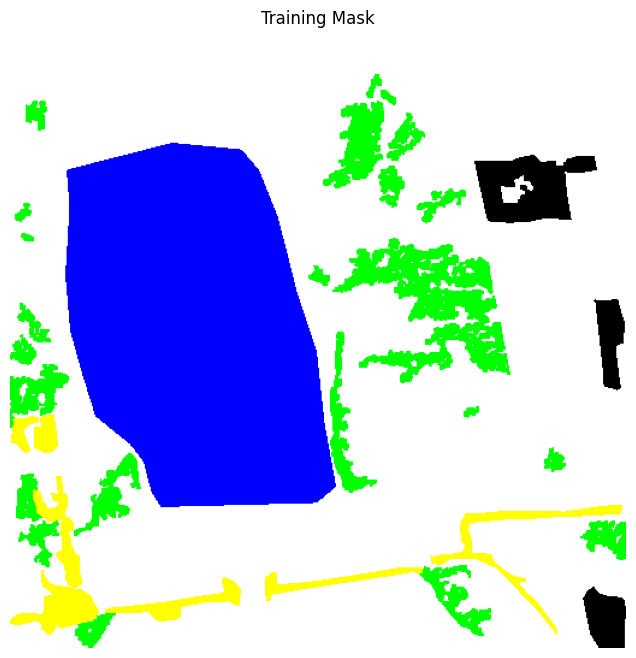

Accuracy: 98.36%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15630
           1       0.98      0.99      0.98      5950
           2       0.91      0.93      0.92      1915
           3       0.95      0.92      0.93      2300

    accuracy                           0.98     25795
   macro avg       0.96      0.96      0.96     25795
weighted avg       0.98      0.98      0.98     25795



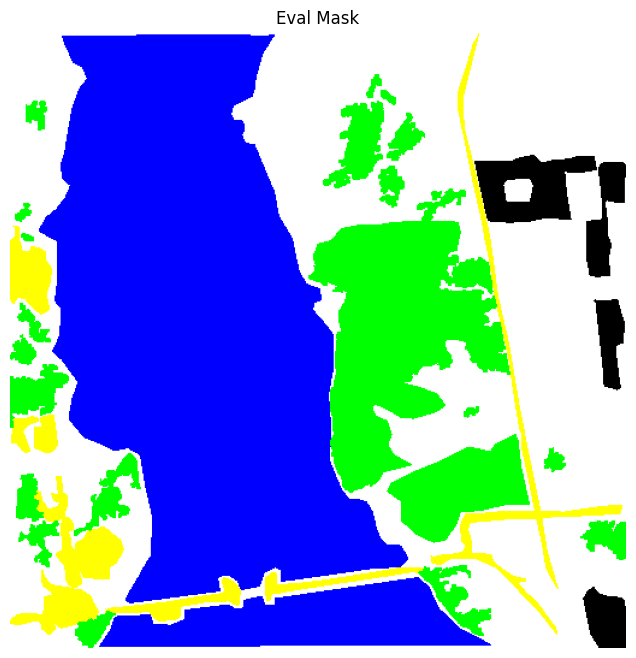

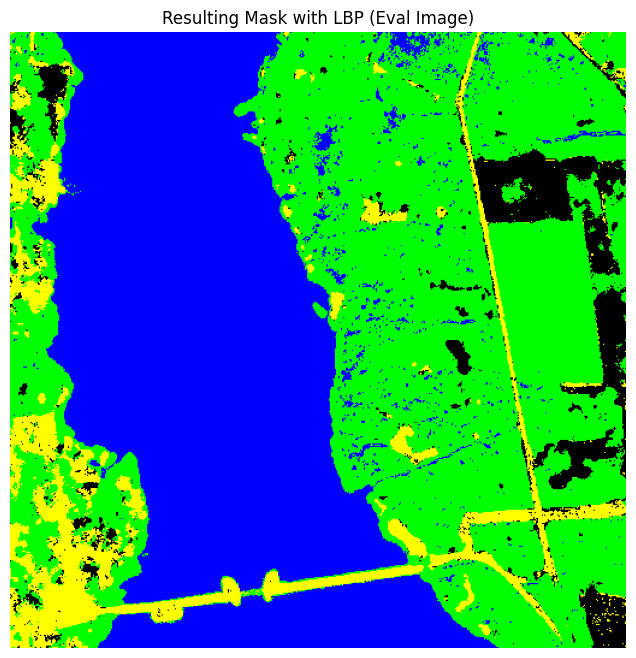

Unique colors in eval_mask (BGR): {(0, 0, 0): 7898, (0, 255, 0): 38258, (0, 255, 255): 12154, (255, 0, 0): 96852, (255, 255, 255): 106982}
Evaluation Accuracy on Eval Image: 97.42%
Evaluation Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     96852
           1       0.97      0.96      0.96     38258
           2       0.87      0.93      0.90      7898
           3       0.97      0.86      0.91     12154

    accuracy                           0.97    155162
   macro avg       0.95      0.94      0.94    155162
weighted avg       0.97      0.97      0.97    155162

Time taken for first image pair processing: 145.28 seconds


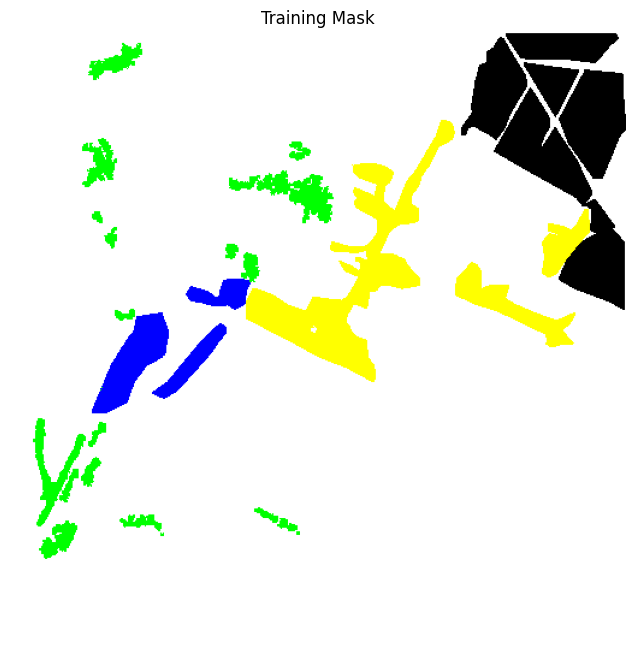

Accuracy: 95.90%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1246
           1       0.92      0.93      0.92      1796
           2       0.97      0.97      0.97      4548
           3       0.96      0.95      0.96      3434

    accuracy                           0.96     11024
   macro avg       0.96      0.96      0.96     11024
weighted avg       0.96      0.96      0.96     11024



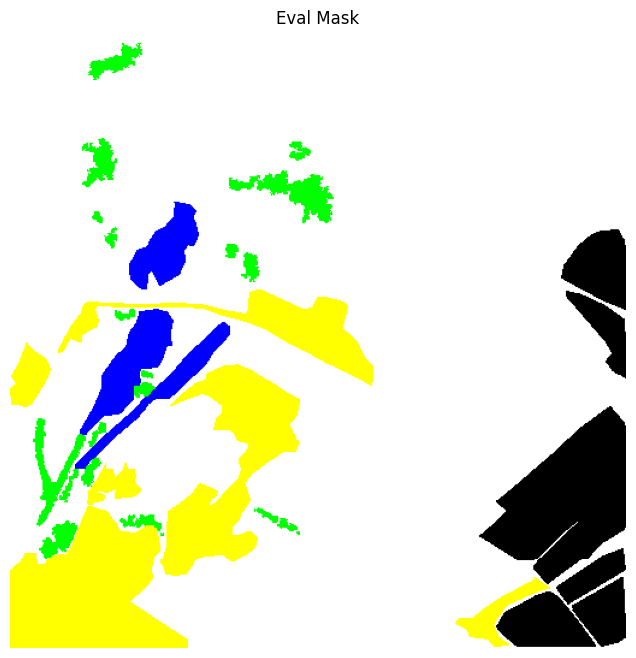

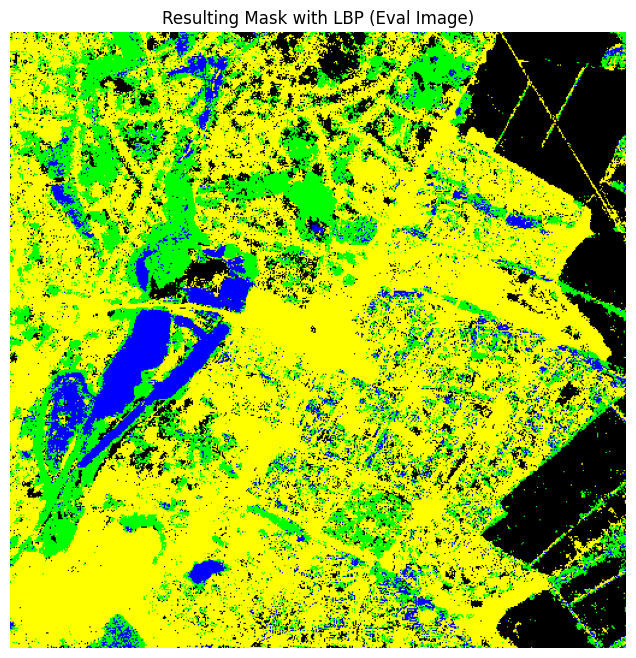

Unique colors in eval_mask (BGR): {(0, 0, 0): 19125, (0, 255, 0): 6032, (0, 255, 255): 28040, (255, 0, 0): 7117, (255, 255, 255): 201830}
Evaluation Accuracy on Eval Image: 89.91%
Evaluation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      7117
           1       0.58      0.98      0.73      6032
           2       0.97      0.89      0.93     19125
           3       0.97      0.94      0.95     28040

    accuracy                           0.90     60314
   macro avg       0.86      0.88      0.85     60314
weighted avg       0.92      0.90      0.90     60314

Time taken for second image pair processing: 137.63 seconds
Total time taken: 282.91 seconds


In [90]:
if __name__ == "__main__":
    # Підрахунок часу для всього процесу
    total_start_time = time.perf_counter()

    # --- Обробка першого набору зображень ---
    process_start_time = time.perf_counter()
    
    # Шляхи до зображень   
    image_path = "Images/sentinel/SS1/SS1.bmp"
    eval_image_path = "Images/sentinel/SS1/SS1.bmp"  # Шумлене зображення
    
    # Шляхи до масок
    train_mask_path = "Images/sentinel/SS1/Samples1.bmp"  # Маска для тренування
    eval_mask_path = "Images/sentinel/SS1/Etalon1.bmp"  # Маска для оцінки точності класифікації (повна)
    
    # Завантажуємо зображення та маски
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    eval_image = cv2.imread(eval_image_path, cv2.IMREAD_COLOR)  # Зашумлене зображення
    train_mask = cv2.imread(train_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask = cv2.imread(eval_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask_rgb = cv2.cvtColor(eval_mask, cv2.COLOR_BGR2RGB) # Маска для оцінки точності

    # Встановлюємо колір-клас відповідність:
    color_to_class = {
        (0, 0, 255): 0,    # Синій - Вода
        (0, 255, 0): 1,    # Зелений - Рослинність
        (0, 0, 0): 2,      # Чорний - Відкритий ґрунт
        
        (255, 255, 0): 3   # Жовтий - Урбанізація
    }

    class_to_color = {v: k for k, v in color_to_class.items()}  # Зворотня відповідність для класифікованого результату

    # === Тренування моделі ===
    sampled_coordinates, sampled_labels, training_mask = prepare_data_with_colored_mask(
        rgb_image, train_mask, color_to_class, pixel_sample_percentage=1.0
    )

    # Візуалізуємо вибрану тренувальну маску
    training_mask_rgb = cv2.cvtColor(training_mask, cv2.COLOR_BGR2RGB)  # Переводимо в RGB для matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(training_mask_rgb)
    plt.axis('off')
    plt.title("Training Mask")
    plt.show()
    cv2.imwrite("Images/temp/training_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу

    # # Only RGB
    # features = extract_pixel_features_rgb(
    #     rgb_image, sampled_coordinates
    # )

    # # Only LBP
    # features = extract_pixel_features_rgb_with_lbp(
    #     rgb_image, sampled_coordinates, radius=2, n_points=16
    # )

    # LBP + RGB
    features = extract_pixel_features_rgb_with_lbp_and_colors(
        rgb_image, sampled_coordinates, radius=2, n_points=16
    )

    # Тренуємо модель XGBoost
    model = train_xgboost_classifier(features, sampled_labels)
    
    # # === Класифікація чистого зображення ===
    # resulting_mask = classify_entire_image(
    #     rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=False, use_lbp=True
    # )
    # resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB для matplotlib
    # plt.figure(figsize=(8, 8))
    # plt.imshow(resulting_mask)
    # plt.axis('off')
    # plt.title("Resulting Mask with Color (Clean Image)")
    # plt.show()
    # cv2.imwrite("Images/temp/result_colored_mask_lbp_clean.png", resulting_mask_rgb)  # Зберігаємо результат
    
    # === Класифікація первірочного зображення ===   

    # Візуалізуємо вибрану перевірочну маску
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_mask_rgb)
    plt.axis('off')
    plt.title("Eval Mask")
    plt.show()
    cv2.imwrite("Images/temp/eval_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу
    
    eval_resulting_mask = classify_entire_image(
        eval_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=True, use_lbp=True
    )
    eval_resulting_mask_rgb = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_resulting_mask)
    plt.axis('off')
    plt.title("Resulting Mask with LBP (Eval Image)")
    plt.show()
    cv2.imwrite("Images/temp/eval_result_colored_mask_lbp.png", eval_resulting_mask_rgb)  # Зберігаємо результат
    
    # === Оцінка точності на основі повної маски ===
    eval_resulting_mask_bgr = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_RGB2BGR)

    # Виведення унікальних кольорів у масці
    unique_colors_eval, counts_eval = np.unique(eval_mask.reshape(-1, 3), axis=0, return_counts=True)
    print("Unique colors in eval_mask (BGR):", dict(zip(map(tuple, unique_colors_eval), counts_eval)))
    
    eval_accuracy, eval_report = evaluate_classification_results(
        eval_resulting_mask, eval_mask_rgb, color_to_class
    )
    
    # Виведення результатів
    print(f"Evaluation Accuracy on Eval Image: {eval_accuracy * 100:.2f}%")
    print("Evaluation Classification Report:")
    print(eval_report)

    # Показуємо час для першого зображення
    process_end_time = time.perf_counter()
    print(f"Time taken for first image pair processing: {process_end_time - process_start_time:.2f} seconds")







    
    # --- Обробка другого набору зображень ---
    process_start_time = time.perf_counter()
    
    # Шляхи до зображень   
    image_path = "Images/sentinel/SS2/SS2.bmp"
    eval_image_path = "Images/sentinel/SS2/SS2.bmp"  # Шумлене зображення
    
    # Шляхи до масок
    train_mask_path = "Images/sentinel/SS2/Samples2.bmp"  # Маска для тренування
    eval_mask_path = "Images/sentinel/SS2/Etalon2.bmp"  # Маска для оцінки точності класифікації (повна)
    
    # Завантажуємо зображення та маски
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    eval_image = cv2.imread(eval_image_path, cv2.IMREAD_COLOR)  # Зашумлене зображення
    train_mask = cv2.imread(train_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask = cv2.imread(eval_mask_path, cv2.IMREAD_COLOR)  # Маска для тренування
    eval_mask_rgb = cv2.cvtColor(eval_mask, cv2.COLOR_BGR2RGB) # Маска для оцінки точності

    # Встановлюємо колір-клас відповідність:
    color_to_class = {
        (0, 0, 255): 0,    # Синій - Вода
        (0, 255, 0): 1,    # Зелений - Рослинність
        (0, 0, 0): 2,      # Чорний - Відкритий ґрунт
        
        (255, 255, 0): 3   # Жовтий - Урбанізація
    }

    class_to_color = {v: k for k, v in color_to_class.items()}  # Зворотня відповідність для класифікованого результату

    # === Тренування моделі ===
    sampled_coordinates, sampled_labels, training_mask = prepare_data_with_colored_mask(
        rgb_image, train_mask, color_to_class, pixel_sample_percentage=1.0
    )

    # Візуалізуємо вибрану тренувальну маску
    training_mask_rgb = cv2.cvtColor(training_mask, cv2.COLOR_BGR2RGB)  # Переводимо в RGB для matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(training_mask_rgb)
    plt.axis('off')
    plt.title("Training Mask")
    plt.show()
    cv2.imwrite("Images/temp/training_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу

    # Only RGB
    # features = extract_pixel_features_rgb(
    #     rgb_image, sampled_coordinates
    # )

    # # Only LBP
    # features = extract_pixel_features_rgb_with_lbp(
    #     rgb_image, sampled_coordinates, radius=2, n_points=16
    # )

    # LBP + RGB
    features = extract_pixel_features_rgb_with_lbp_and_colors(
        rgb_image, sampled_coordinates, radius=2, n_points=16
    )

    # Тренуємо модель XGBoost
    model = train_xgboost_classifier(features, sampled_labels)
    
    # # === Класифікація чистого зображення ===
    # resulting_mask = classify_entire_image(
    #     rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=False, use_lbp=True
    # )
    # resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB для matplotlib
    # plt.figure(figsize=(8, 8))
    # plt.imshow(resulting_mask)
    # plt.axis('off')
    # plt.title("Resulting Mask with LBP (Clean Image)")
    # plt.show()
    # cv2.imwrite("Images/temp/result_colored_mask_lbp_clean.png", resulting_mask_rgb)  # Зберігаємо результат
    
    # === Класифікація первірочного зображення ===   

    # Візуалізуємо вибрану перевірочну маску
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_mask_rgb)
    plt.axis('off')
    plt.title("Eval Mask")
    plt.show()
    cv2.imwrite("Images/temp/eval_mask.png", training_mask)  # Зберігаємо тренувальну маску для аналізу
    
    eval_resulting_mask = classify_entire_image(
        eval_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1], use_color=True, use_lbp=True
    )
    eval_resulting_mask_rgb = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_BGR2RGB)  # Формат RGB
    plt.figure(figsize=(8, 8))
    plt.imshow(eval_resulting_mask)
    plt.axis('off')
    plt.title("Resulting Mask with LBP (Eval Image)")
    plt.show()
    cv2.imwrite("Images/temp/eval_result_colored_mask_lbp.png", eval_resulting_mask_rgb)  # Зберігаємо результат
    
    # === Оцінка точності на основі повної маски ===
    eval_resulting_mask_bgr = cv2.cvtColor(eval_resulting_mask, cv2.COLOR_RGB2BGR)

    # Виведення унікальних кольорів у масці
    unique_colors_eval, counts_eval = np.unique(eval_mask.reshape(-1, 3), axis=0, return_counts=True)
    print("Unique colors in eval_mask (BGR):", dict(zip(map(tuple, unique_colors_eval), counts_eval)))
    
    eval_accuracy, eval_report = evaluate_classification_results(
        eval_resulting_mask, eval_mask_rgb, color_to_class
    )
    
    # Виведення результатів
    print(f"Evaluation Accuracy on Eval Image: {eval_accuracy * 100:.2f}%")
    print("Evaluation Classification Report:")
    print(eval_report)

    # Показуємо час для другого зображення
    process_end_time = time.perf_counter()
    print(f"Time taken for second image pair processing: {process_end_time - process_start_time:.2f} seconds")

    # Підрахунок загального часу роботи програми
    total_end_time = time.perf_counter()
    print(f"Total time taken: {total_end_time - total_start_time:.2f} seconds")

---

## Підсумок

Скрипт складається з кількох модулів, які відповідають за різні етапи роботи класифікатора. Основний класифікатор працює на основі **LBP (Local Binary Patterns)** для текстурних ознак і кольорових ознак (RGB). На кожному пікселі (попіксельно) витягуються ознаки для навчання моделі **XGBoost**, яка потім використовується для класифікації кожного пікселя на новому зображенні.

---

### Основні функції в скрипті

1. **`prepare_data_with_colored_mask`**:
   Ця функція забезпечує підготовку даних для навчання класифікатора. Вона:
   - Вибирає координати пікселів із маски (`mask`), які позначені кольором.
   - Перетворює кольори маски у класи відповідно до заданого словника (`color_to_class`).
   - Вибірково бере частину пікселів (визначається параметром `pixel_sample_percentage`), що дозволяє навчати класифікатор на меншій і більш репрезентативній вибірці даних.

   **Конфігурування:**
   - **`pixel_sample_percentage`:**
     - Якщо класи сильно незбалансовані, збільшіть відсоток (наприклад, `0.7` або `1.0`), щоб захопити більше даних для рідкісних класів.
     - Зменшіть його для дуже великих масок і зображень, щоб уникнути високої обчислювальної складності.

   **Приклад виклику:**
   ```python
   sampled_coordinates, sampled_labels = prepare_data_with_colored_mask(
       rgb_image, mask, color_to_class, pixel_sample_percentage=0.5
   )
   ```

---

2. **`extract_pixel_features_rgb_with_lbp_and_colors`**:
   Ця функція витягує ознаки для кожного пікселя:
   - **LBP:** Текстурні ознаки, що відображають зміни яскравості в локальній області навколо пікселя (`radius`/`n_points`).
   - **RGB:** Кольорові значення пікселя (R, G, B).

   Усі ці компоненти об'єднуються в один вектор ознак, який використовується для навчання XGBoost.

   **Конфігурування:**
   - **`radius`:**
     - Радіус LBP визначає розмір локального контексту. Малий радіус (`1`–`2`) працює для текстур із дрібними деталями, великий радіус (`3`–`5`) — для більш широких текстур.
   - **`n_points`:**
     - Визначає кількість точок (пікселів) для LBP. Типово `n_points = 8 * radius`.
   - **`method`:**
     - Метод розрахунку LBP. Типово `"uniform"` для більш стабільних ознак.

   **Приклад виклику:**
   ```python
   features = extract_pixel_features_rgb_with_lbp_and_colors(
       rgb_image, sampled_coordinates, radius=2, n_points=16
   )
   ```

---

3. **`train_xgboost_classifier`**:
   Ця функція тренує модель XGBoost на основі витягнутих ознак (`features`) і класів пікселів (`labels`).

   **Конфігурування:**
   - **Hyperparameters in XGBoost (настроювані параметри):**
     - **`n_estimators` (кількість дерев):** Збільшіть до `200–300` для покращення точності моделі.
     - **`max_depth` (глибина дерев):** Баланс між деталізацією моделі та її схильністю до переобучення. Оптимально `4–8`.
     - **`eta` (learning_rate):** Зменште до `0.1` або `0.05` для більш плавного навчання моделі.

   **Приклад виклику:**
   ```python
   model = train_xgboost_classifier(features, sampled_labels)
   ```

---

4. **`classify_entire_image`**:
   Ця функція класифікує кожен піксель нового зображення, використовуючи натреновану модель XGBoost.

   - Витягує ознаки за допомогою LBP і RGB значень.
   - Передбачає клас кожного пікселя та генерує фінальну відобрачену маску у форматі RGB (або BGR).

   **Конфігурування:**
   - Параметри витягнення ознак (`radius`, `n_points`) повинні співпадати з навчальними.
   - Якщо виникають проблеми з розміром вектора ознак, використовуйте автоматичний підгін:
     ```python
     expected_size = features.shape[1]  # Отримане з навчальних даних
     feature_vector = np.pad(feature_vector, (0, expected_size - feature_vector.shape[0]), mode='constant')
     ```

   **Приклад виклику:**
   ```python
   resulting_mask = classify_entire_image(
       rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=expected_size
   )
   ```

---

### Загальна структура функцій

##### **Основний алгоритм**:
```python
if __name__ == "__main__":
    # 1. Завантажуємо зображення та маску.
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

    # 2. Готуємо координати та класи для навчання за маскою.
    sampled_coordinates, sampled_labels = prepare_data_with_colored_mask(
        rgb_image, mask, color_to_class, pixel_sample_percentage=0.5
    )

    # 3. Витягуємо ознаки LBP та кольору.
    features = extract_pixel_features_rgb_with_lbp_and_colors(
        rgb_image, sampled_coordinates, radius=2, n_points=16
    )

    # 4. Навчаємо модель XGBoost.
    model = train_xgboost_classifier(features, sampled_labels)

    # 5. Класифікуємо кожен піксель нового зображення.
    resulting_mask = classify_entire_image(
        rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1]
    )

    # 6. Зберігаємо фінальну класифікаційну маску.
    resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)
    cv2.imwrite("Images/temp/result_colored_mask_lbp.png", resulting_mask_rgb)
    plt.imshow(resulting_mask_rgb)
    plt.show()
```

---

## Конфігурування класифікатора

1. **`pixel_sample_percentage` для навчання:**
   - Змінюйте цей параметр, щоб контролювати кількість прикладів для навчання.
   - При дисбалансі класів рекомендую збільшити до `0.6–0.8`.

2. **`radius` і `n_points` для LBP:**
   - **Малі значення (`radius=1`, `n_points=8`)** — для дрібних текстур.
   - **Великі значення (`radius=3–5`, `n_points=16–24`)** — для більш обширних текстур.

3. **Параметри XGBoost:**
   - **`learning_rate (eta)`**:
     - Зменште до `0.05` для досконалого навчання.
   - **`max_depth`**:
     - Зменшіть до `4–6`, якщо модель перевчена.

4. **Гіперпараметри через `GridSearchCV`**:
   Використовуйте:
   ```python
   from sklearn.model_selection import GridSearchCV

   param_grid = {
       'n_estimators': [100, 200, 300],
       'max_depth': [4, 6, 8],
       'learning_rate': [0.05, 0.1, 0.2]
   }

   grid_search = GridSearchCV(xgb.XGBClassifier(objective='multi:softmax', num_class=4), param_grid, cv=3)
   grid_search.fit(features, sampled_labels)

   print("Best parameters:", grid_search.best_params_)
   ```

5. **Підгін розмірів ознак (інференс):**
   Якщо отримуєте помилки через розмір вектора, програма автоматично коригує це за допомогою `np.pad`.

---

## Висновок

Класифікатор:
- Ефективний для аналізу текстур і кольорів на зображенні.
- Може бути легко сконфігурований для різних задач, залежно від розміру маски, кількості класів, та рівня текстур.

### Рекомендації:
1. Налаштуйте **`pixel_sample_percentage`**, щоб захопити достатньо даних.
2. Проведіть **гіперпараметричний пошук `GridSearchCV`** для оптимізації XGBoost.
3. Тестуйте різні **`radius` та `n_points`**, щоб знайти оптимальні налаштування для вашої текстури.